# Nissan reconstructed Stable Diffusion notebook


> Make sure I have the right GPU enabled with sufficient capacity to run the models

In [1]:
import torch

In [2]:
# From pytorch docs that allows for Mac GPU training as well
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [3]:
torch.cuda.get_device_name()

'NVIDIA TITAN RTX'

## My attempt to grok the underlying bits

In [635]:
prompts = [
    'a high quality photograph of a majestic castle with a garden of hummingbirds, purple hibiscus flowers and blue roses with anime styled touch-ups.',
    'classic oil painting of a majestic castle with a garden of hummingbirds, purple hibiscus flowers and blue roses in the style of Michel-Jean Cazabon.',
    'a water colors painting of a majestic castle with a garden of hummingbirds, purple hibiscus flowers and blue roses in the style of Samizu Matsuki.'
]

In [636]:
height = 512
width = 512
num_inference_steps = 70 #changed from 70 to get crisper pictures but that didn't seem to affect the quality
guidance_scale = 7.5 # changed to less to allow more originality maybe?
batch_size = 1 #default

In [6]:
from transformers import CLIPTextModel, CLIPTokenizer

2023-08-27 13:45:58.051090: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 13:45:58.934930: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)

In [637]:
text_input = tokenizer(prompts, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

In [9]:
text_input['input_ids']

tensor([[49406,   320, 16157,  1315,  8853,   539,   320, 36654,   267,   320,
         25513,   537,   550, 13828, 14952,   536,   518,  2117, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407],
        [49406,   550,  2870,  3086,   539,   320, 36654,   267,   320, 25513,
           537,   550, 13828, 14952,   536,   518,  2117,   530,   518,  1844,
           539, 36001, 16068,  2982, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 

In [10]:
text_input['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])

In [11]:
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

In [638]:
text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0].half()

In [13]:
text_embeddings.shape

torch.Size([3, 77, 768])

### Setup unconditional inputs

In [639]:
max_length = text_input.input_ids.shape[-1]

In [640]:
batch_size=len(prompts)

In [641]:
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")

In [642]:
uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0].half()

In [643]:
uncond_embeddings.shape

torch.Size([3, 77, 768])

In [644]:
emb = torch.cat([uncond_embeddings, text_embeddings]) # done to batch the 2 forward passes needed into one

In [645]:
torch.manual_seed(100)
g = guidance_scale

### Setup the scheduler

In [21]:
import matplotlib.pyplot as plt

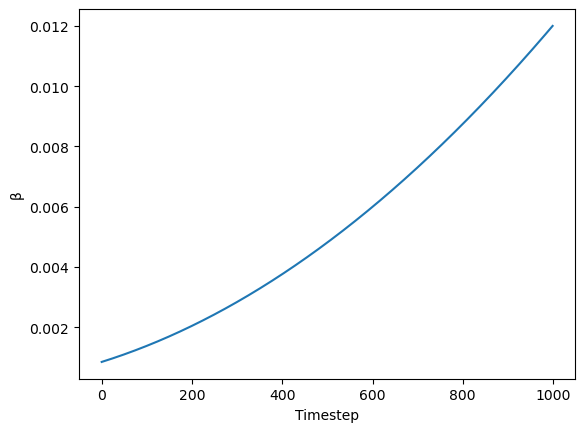

In [22]:
beta_start,beta_end = 0.00085,0.012
plt.plot(torch.linspace(beta_start**0.5, beta_end**0.5, 1000) ** 2)
plt.xlabel('Timestep')
plt.ylabel('β');

In [23]:
from diffusers import LMSDiscreteScheduler

In [24]:
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [646]:
scheduler.set_timesteps(num_inference_steps)

In [26]:
scheduler.timesteps

tensor([999.0000, 988.9091, 978.8182, 968.7273, 958.6364, 948.5455, 938.4545,
        928.3636, 918.2727, 908.1818, 898.0909, 888.0000, 877.9091, 867.8182,
        857.7273, 847.6364, 837.5455, 827.4545, 817.3636, 807.2727, 797.1818,
        787.0909, 777.0000, 766.9091, 756.8182, 746.7273, 736.6364, 726.5455,
        716.4545, 706.3636, 696.2727, 686.1818, 676.0909, 666.0000, 655.9091,
        645.8182, 635.7273, 625.6364, 615.5455, 605.4545, 595.3636, 585.2727,
        575.1818, 565.0909, 555.0000, 544.9091, 534.8182, 524.7273, 514.6364,
        504.5455, 494.4545, 484.3636, 474.2727, 464.1818, 454.0909, 444.0000,
        433.9091, 423.8182, 413.7273, 403.6364, 393.5455, 383.4545, 373.3636,
        363.2727, 353.1818, 343.0909, 333.0000, 322.9091, 312.8182, 302.7273,
        292.6364, 282.5455, 272.4545, 262.3636, 252.2727, 242.1818, 232.0909,
        222.0000, 211.9091, 201.8182, 191.7273, 181.6364, 171.5455, 161.4545,
        151.3636, 141.2727, 131.1818, 121.0909, 111.0000, 100.90

In [27]:
scheduler.sigmas

tensor([14.6146, 13.7525, 12.9525, 12.2094, 11.5188, 10.8763, 10.2782,  9.7209,
         9.2012,  8.7162,  8.2633,  7.8399,  7.4439,  7.0732,  6.7258,  6.4002,
         6.0946,  5.8077,  5.5381,  5.2845,  5.0458,  4.8210,  4.6092,  4.4093,
         4.2207,  4.0425,  3.8740,  3.7146,  3.5637,  3.4207,  3.2852,  3.1565,
         3.0344,  2.9183,  2.8079,  2.7029,  2.6029,  2.5076,  2.4167,  2.3299,
         2.2470,  2.1678,  2.0921,  2.0196,  1.9502,  1.8836,  1.8198,  1.7585,
         1.6996,  1.6431,  1.5886,  1.5362,  1.4858,  1.4371,  1.3902,  1.3449,
         1.3012,  1.2589,  1.2180,  1.1784,  1.1400,  1.1028,  1.0667,  1.0317,
         0.9976,  0.9646,  0.9324,  0.9010,  0.8705,  0.8407,  0.8116,  0.7832,
         0.7555,  0.7283,  0.7017,  0.6757,  0.6501,  0.6250,  0.6003,  0.5760,
         0.5521,  0.5285,  0.5051,  0.4820,  0.4592,  0.4364,  0.4138,  0.3912,
         0.3687,  0.3460,  0.3231,  0.2999,  0.2763,  0.2520,  0.2267,  0.2001,
         0.1712,  0.1386,  0.0987,  0.02

### Set the initial latents

In [28]:
!pip install accelerate

In [29]:
from diffusers import UNet2DConditionModel

In [30]:
# unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

In [653]:
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet", torch_dtype=torch.float16).to("cuda") # Change to use more recent model

In [647]:
# unet = UNet2DConditionModel.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", subfolder="unet", torch_dtype=torch.float16).to("cuda") # Does not work, some more tweaking to do here

In [654]:
latents = torch.randn((batch_size, unet.config.in_channels, height // 8, width // 8))

In [655]:
latents = latents.to("cuda").half() * scheduler.init_noise_sigma

### Do the generation

In [656]:
from tqdm.auto import tqdm

In [657]:
for i,ts in enumerate(tqdm(scheduler.timesteps)):
    inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
    with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
    pred = u + g*(t-u)
    latents = scheduler.step(pred, ts, latents).prev_sample

  0%|          | 0/70 [00:00<?, ?it/s]

In [128]:
from diffusers import AutoencoderKL

In [658]:
# Here we use a different VAE to the original release, which has been fine-tuned for more steps
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")

In [619]:
# Trying a different VAE to see what happens
# vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16).to("cuda")

In [659]:
with torch.no_grad(): image = vae.decode(1 / 0.18215 * latents).sample
res = (image / 2 + 0.5).clamp(0, 1)

In [660]:
from PIL import Image

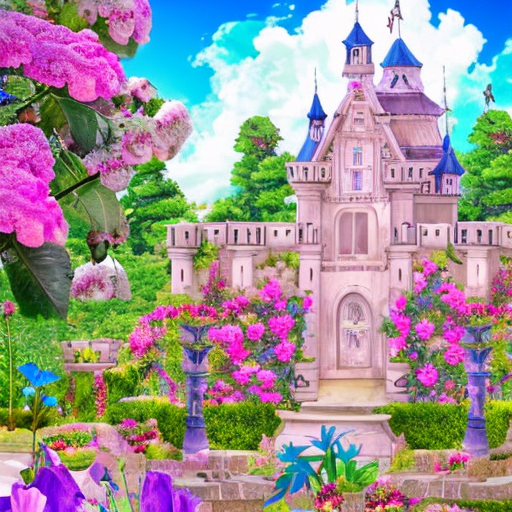

In [661]:
image = res[0].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)

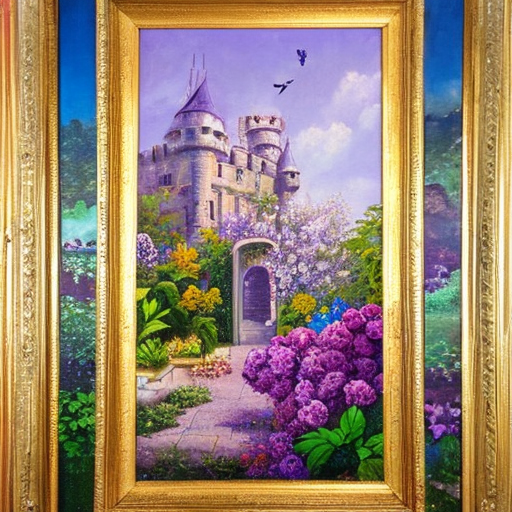

In [662]:
image2 = res[1].detach().cpu().permute(1, 2, 0).numpy()
image2 = (image2 * 255).round().astype("uint8")
Image.fromarray(image2)

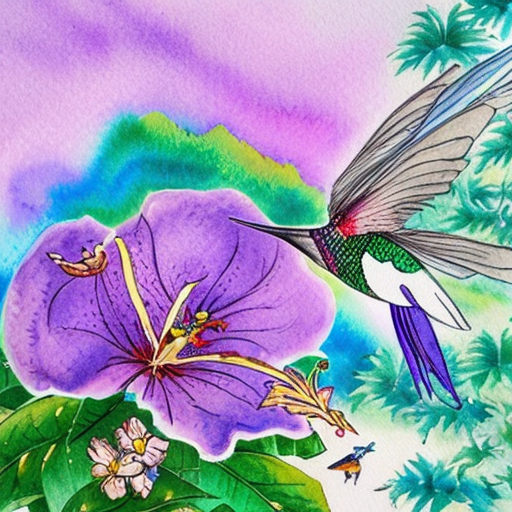

In [663]:
image3 = res[2].detach().cpu().permute(1, 2, 0).numpy()
image3 = (image3 * 255).round().astype("uint8")
Image.fromarray(image3)